In [1]:
import numpy as np


import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="whitegrid")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

import pickle

In [2]:
# TODO - add the full path to the repository
import sys
sys.path.append('PATH-TO/pararel/')

In [3]:
from pararel.consistency import utils

In [4]:
with open('../data/trex/data/relations.jsonl', 'r') as f:
    lines = f.readlines()
    lines = [x.strip() for x in lines]
    
json_lines = [json.loads(x) for x in lines]
pid2label = {x['relation']: x['label'] for x in json_lines}
pid2type = {x['relation']: x['type'] for x in json_lines}

In [5]:
def get_data(rel_id, model):
    data = utils.read_jsonl_file('../data/trex_lms_vocab/{}.jsonl'.format(rel_id))

    prompts = utils.load_prompts('../data/pattern_data/graphs_json/{}.jsonl'.format(rel_id))

    representations = np.load('../data/output/representations/{}_{}.npy'.format(rel_id, model))
    
    with open('../data/pattern_data/graphs/{}.graph'.format(rel_id), 'rb') as f:
        graph = pickle.load(f)
    graph_nodes = [x.lm_pattern for x in graph.nodes]
    
    filt_prompts, filt_representations = [], []
    for p, r in zip(prompts, representations):
        if p in graph_nodes:
            filt_prompts.append(p)
            filt_representations.append(r)
        
    
    return data, filt_prompts, np.array(filt_representations)

In [6]:
with open('../data/trex/data/relations.jsonl', 'r') as f:
    rels = f.readlines()
    rels = [json.loads(x)['relation'] for x in rels]

In [7]:
len(rels)

46

In [8]:
def get_table_data(data, prompts, representations, subjs_n=30):
    table_data = []

    for prompt_ind, prompt in enumerate(prompts):
        for datum_ind, datum in enumerate(data):
            if datum_ind >= subjs_n:
                continue
            table_data.append([prompt, datum['obj_label'], representations[prompt_ind, datum_ind]])
    return table_data

In [9]:
model2rel2df = {}
model2rel2table = {}

In [10]:
from copy import deepcopy

In [11]:
for model in [
#     'bert-base-cased', 
    'bert-large-cased'#, 'bert-large-cased-whole-word-masking',
             #'roberta-base', 'roberta-large',
              #'albert-base-v2', 'albert-xxlarge-v2'
            ]:

    rel2df = {}
    rel2table = {}

    for ind, x in enumerate(rels):
        print(x)
        if x in ['P279', 'P166', 'P69', 'P54', 'P1923', 'P102', 'P361']:
            continue
        
        if x not in ['P36']: continue

        try:
            data, prompts, representations = get_data(x, model)
            table_data = get_table_data(data, prompts, representations)
        except:
            continue
        rel2table[x] = table_data

        n = 1000
        try:

            tsne = TSNE(n_components=2, perplexity=20, early_exaggeration=4.0, learning_rate=1000, n_iter=1000,
                        n_iter_without_progress=50, min_grad_norm=0, method='exact', verbose=2)
            Y = tsne.fit_transform(np.array([x[2] for x in table_data[:n]]))
        except:
            pass

        temp = np.concatenate([[Y[:, 0]], [Y[:, 1]],
                           [[x[0] for x in table_data[:n]]],
                          [[x[1] for x in table_data[:n]]]], axis=0).T

        df = pd.DataFrame(temp, columns=['x', 'y', 'pattern', 'subject'])
        df['x'] = df['x'].astype(float)
        df['y'] = df['y'].astype(float)

        rel2df[x] = df
        
    model2rel2df[model] = rel2df
    model2rel2table[model] = rel2table

P19
P20
P279
P37
P413
P166
P449
P69
P47
P138
P364
P54
P463
P101
P1923
P106
P527
P102
P530
P176
P27
P407
P30
P178
P1376
P131
P1412
P108
P136
P17
P39
P264
P276
P937
P140
P1303
P127
P103
P190
P1001
P31
P495
P159
P36
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 420 / 420
[t-SNE] Mean sigma: 4.964180
[t-SNE] Iteration 50: error = 14.5516427, gradient norm = 0.1230429 (50 iterations in 0.443s)
[t-SNE] Iteration 100: error = 13.9938840, gradient norm = 0.1218216 (50 iterations in 0.356s)
[t-SNE] Iteration 150: error = 13.9847044, gradient norm = 0.1190779 (50 iterations in 0.357s)
[t-SNE] Iteration 200: error = 14.0823956, gradient norm = 0.1156330 (50 iterations in 0.355s)
[t-SNE] Iteration 250: error = 13.5641920, gradient norm = 0.1243826 (50 iterations in 0.363s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 13.564192
[t-SNE] Iteration 300: error = 0.3810566, gradient norm = 0.0090412 (50 iterations in 0.354s)
[t-SNE] 

In [12]:
model2rel2df.keys()

dict_keys(['bert-large-cased'])

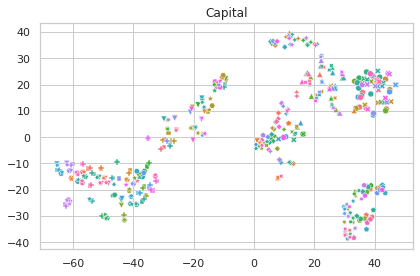

In [13]:
ax = sns.scatterplot(data=model2rel2df['bert-large-cased']['P36'], x='x', y='y', hue='subject', style='pattern', legend=False)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Capital')

plt.tight_layout()
# plt.savefig("../figures/capital-bert-large.pdf")